# Generate Training Data

- Divide the goal up into equally-spaced regions
- Draw a grid around the goal
- Go through this grid and generate a kick that will land exactly there

### 2D Deterministic Data Generator

In [59]:
X_GOAL = 3
GOAL_HEIGHT = 2.5

In [60]:
NUM_XS_START, NUM_YS_START = 1, 3
NUM_XS_END, NUM_YS_END = 5, 10
TIME_STEPS = 10
DECAY = .8
NUM_BETWEEN = 0
NOISE_LEVEL = 0

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


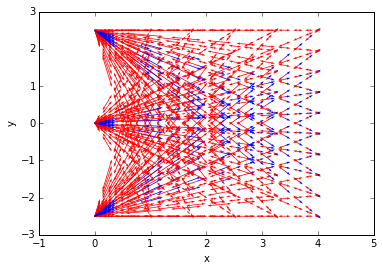

In [61]:
import math
import random

import itertools
from collections import namedtuple

from numpy.random import randn

State = namedtuple('State', ['x', 'y', 'dx', 'dy', 'distance', 'bearing', 'shot_number', 'label'])
World = namedtuple('World', ['goal', 'end'])

def data_generator(num_xs_start=2, num_ys_start=2, num_xs_end=2, num_ys_end=2, time_steps=10, decay=.8, noise=0):
    """Generate data from a fixed set of grid points
    
    Parameters
    ----------
    num_ends_x : int
    The number of ending points in the x direction you want
    
    num_ends_y : int
    The number of ending points in the y direction you want
    
    time_steps : int
    The number of time steps for the ball to get to the robot. This number should be calculated based on
    the assumption that we're operating at 50 Hz. A reasonable number of time steps would thus be 100 (2 seconds)
    
    decay : float
    The constant decay rate of the velocity of the ball
    
    noise : float
    the amount of noise present
    
    """ 
    xs_start, ys_start = np.linspace(0, 1, num_xs_start), np.linspace(-2.5, 2.5, num_ys_start)
    starts = itertools.product(xs_start, ys_start)
    
    # Create grid of end points
    xs_end, ys_end = np.linspace(1, 4, num_xs_end), np.linspace(-2.5, 2.5, num_ys_end)
    ends = itertools.product(xs_end, ys_end)
    shot_number = 0
    for (x_start, y_start), (x_end, y_end) in itertools.product(starts, ends):
        if x_end < X_GOAL:
            label = 0
        else:
            # Draw a line and see where the ball intersects
            slope = (y_end-y_start) / (x_end-x_start)
            y = slope*(X_GOAL-x_start) + y_start
            label = 1 if -GOAL_HEIGHT/2 <= y <= GOAL_HEIGHT/2 else 0
        
        # Starting velocities to reach the destination
        c = (1-decay) / (1-decay**(time_steps-1))
        dx_start = c * (x_end-x_start)
        dy_start = c * (y_end-y_start)

        # Calculate how far you've traveled from the start at each time_step
        decays = np.array([decay**pow for pow in range(time_steps)])

        # Velocity at each time step
        x_velocities = decays * dx_start
        y_velocities = decays * dy_start

        # Distance traveled at each time step
        x_deltas = np.cumsum(x_velocities)
        y_deltas = np.cumsum(y_velocities)

        # Compute the actual points given deltas
        x_positions = x_start + x_deltas
        x_positions = np.append([x_start], x_positions[:-1])
        y_positions = y_start + y_deltas
        y_positions = np.append([y_start], y_positions[:-1])
        
        # Yield the points one by one
        for x, y, dx, dy in zip(x_positions, y_positions, x_velocities, y_velocities):
            # Noise
            x += noise*np.random.randn()
            y += noise*np.random.randn()
            
            dx += noise*np.random.randn()
            dy += noise*np.random.randn()
            
            # Compute distance and bearing exactly from noisy estimates
            distance, bearing = np.sqrt((x-X_GOAL)**2 + (y-0)**2), math.atan(y/(X_GOAL-x)) if x else 0
            
            yield State(x, y, dx, dy, distance, bearing, shot_number, label)
            
        # Yield shots backwards
        for x, y, dx, dy in zip(reversed(x_positions), reversed(y_positions),
                                reversed([0]+x_velocities[:-1]), reversed([0]+y_velocities[:-1])):
            yield State(x, y, -dx, -dy, distance, bearing, shot_number+1, 0)
            
        shot_number += 2

# Generate shot data
data_points = data_generator(num_xs_start=NUM_XS_START, num_ys_start=NUM_YS_START,
                             num_xs_end=NUM_XS_END, num_ys_end=NUM_YS_END,
                             time_steps=TIME_STEPS, decay=DECAY, noise=NOISE_LEVEL)
data_points = list(data_points)

# Plot it
df = pd.DataFrame(data_points, columns=State._fields)
labels = df['label']
colormap = np.array(['r', 'b'])
axes = df.plot(kind='scatter', x='x', y='y', c=colormap[labels], s=0)
axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, width=.0022)

### Class Numbers

In [62]:
df.groupby('label').size()

label
0    2510
1     340
dtype: int64

### Filter Away Points out of Goalie's Field of View

label
0    2218
1     212
dtype: int64

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


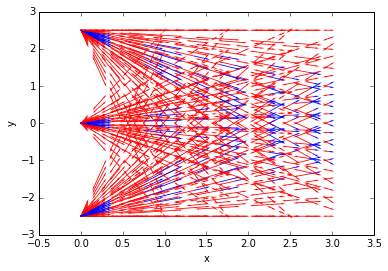

In [63]:
data_points = [data_point for data_point in data_points if not data_point.x > X_GOAL]

df = pd.DataFrame(data_points, columns=State._fields)

# Plot it
labels = df['label']
axes = df.plot(kind='scatter', x='x', y='y', c=colormap[labels], s=0)
axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, headwidth=2)
 
df.groupby('label').size()

### Restore Class Balance

In [64]:
while True:
    num_misses, num_shots = df.groupby('label').size()
    if num_shots > num_misses:
        break

    # Choose an unlucky miss to go
    misses = df[df.label == 0]
    shot_numbers = misses.shot_number.unique()
    unlucky_shot = np.random.choice(shot_numbers, 1)[0]
    mask = (df.label == 0) & (df.shot_number == unlucky_shot)
    
    df = df[~mask]
    
df.groupby('label').size()

label
0    209
1    212
dtype: int64

### Plot Filtered Shots

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


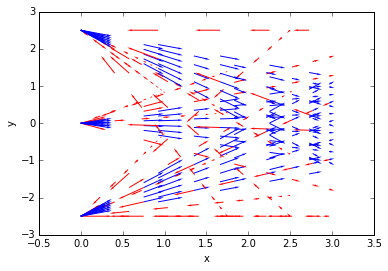

In [65]:
labels = df['label']
axes = df.plot(kind='scatter', x='x', y='y', c=colormap[labels], s=0)
axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, headwidth=2)

In [66]:
df.groupby('label').size()

label
0    209
1    212
dtype: int64

In [67]:
shots = df

%store shots

Stored 'shots' (DataFrame)
